# Heart Failure Mortality: An Unsupervised Clustering Study

---

Unsupervised predictions of patient mortality from congestive heart failure using a dataset of biomarkers and comorbidities.

[Speak to the fact why this is a good candidate for unsupervised learning in the first place.]

Github Repo: https://github.com/chill0121/Unsupervised_Heart_Failure_Mortality

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)
- 5.[**Models**](#models)
- 6.[**Results**](#results)
- 7.[**Conclusion**](#conclusion)
  - 7.1. [Possible Areas for Improvement](#improvements)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


Dataset collected from patients exhibiting heart failure at Faisalabad Institute of Cardiology and Allied Hospital in Faisalabad (Punjab, Pakistan). All patients diagnosed with left ventricular systolic dysfunction and had previous heart failures.

For more detailed information see article published in PLOS One here: https://doi.org/10.1371/journal.pone.0181001

Dataset source: https://plos.figshare.com/articles/dataset/Survival_analysis_of_heart_failure_patients_A_case_study/5227684/1

**Data Info Summary:**
- Accessed and obtained on 7/1/2024.
- Data collected between April and December 2015.

- **Feature Information**
    - **Age:** Integer age of the patient.
    - **Anaemia:** Boolean of whether or not the patient's blood test results indicated anaemia.
    - **Creatine Phosphokinase (CPK):** Measurement of Creatine Phosphokinase levels measured in mcg/L during enzyme blood tests. High levels typically indicate muscle stress or injury.
    - **Diabetes:** Boolean of whether or not the patient has been diagnosed with diabetes.
    - **Ejection Fraction:** Measured as percentage of blood leaving the heart during contraction. $EF = \frac{SV}{EDV} \cdot 100$, where $EF$ is Ejection Fraction, $SV$ is Stroke Volume, and $EDV$ is End Diastolic Volume.
    - **High Blood Pressure:** Boolean of whether or not the patient has been diagnosed with high blood pressure.
    - **Platelets:** Measurement of platelet counts during platelet count test.
    - **Serum Creatinine:** Measurement of creatinine in the patient's blood stream during blood test in mg/dL.
    - **Serum Sodium:** Measurement of sodium in the patient's blood stream during blood test in mEq/L.
    - **Sex:** Binary of patient's biological sex identification (0 = Female, 1 = Male). 
    - **Smoking:** Boolean of whether or not the patient has a history of smoking.
    - **Time:** Integer of follow-up in days.
    - **Death_Event:** Boolean of whether or not the patient died during the follow-up period.

## 2. Setup <a name="setup"></a>

---

In [709]:
import sys
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import kmodes
from kmodes.kprototypes import KPrototypes
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
import xgboost as xgb
from sklearn.svm import SVC
# Logistical Regression

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [710]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, kmodes, sklearn, xgb]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2
<module 'kmodes'  using version: 0.12.2
<module 'sklearn'  using version: 1.3.2
<module 'xgboost'  using version: 2.0.3


### 2.2. Importing the Data: <a name="dataimport"></a>

In [711]:
patient_df = pd.read_csv('./data/clinical_records.csv')

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

Print out some basic information about the dataset.

In [712]:
patient_df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


Rename some of the columns for readability and consistency.

Major changes:

- creatinine_phosphokinase to `CPK`
- high_blood_pressure to `Hypertension`
- smoking to `Smoker`
- time to `Follow_Up_Days`
- DEATH_EVENT to `Death`

In [713]:
patient_df = patient_df.rename(columns = {'age' : 'Age',
                                          'anaemia' : 'Anaemia',
                                          'creatinine_phosphokinase' : 'CPK',
                                          'diabetes' : 'Diabetes',
                                          'ejection_fraction' : 'Ejection_Fraction',
                                          'high_blood_pressure' : 'Hypertension',
                                          'platelets' : 'Platelets',
                                          'serum_creatinine' : 'Serum_Creatinine',
                                          'serum_sodium' : 'Serum_Sodium',
                                          'sex' : 'Sex',
                                          'smoking' : 'Smoker',
                                          'time' : 'Follow_Up_Days',
                                          'DEATH_EVENT' : 'Death'})

Let's now make sure the features have appropriate data types.

In [714]:
patient_df.dtypes

Age                  float64
Anaemia                int64
CPK                    int64
Diabetes               int64
Ejection_Fraction      int64
Hypertension           int64
Platelets            float64
Serum_Creatinine     float64
Serum_Sodium           int64
Sex                    int64
Smoker                 int64
Follow_Up_Days         int64
Death                  int64
dtype: object

- `Age` doesn't need to be a float.
- `Sex` being binary is a little confusing for analysis.

Here, `Age` will be changed into an integer and `Sex` will be changed into a string object for easier readability. It will be changed back to binary before model fitting since many of the models won't support that style of categorical feature.

In [715]:
# Change age to int.
patient_df.Age = patient_df.Age.astype(int)

# Change sex from binary to strings for readability during EDA.
patient_df.Sex = patient_df.Sex.mask(patient_df.Sex == 1, 'Male')
patient_df.Sex = patient_df.Sex.mask(patient_df.Sex == 0, 'Female')

Now let's make sure there are no duplicates or missing entries.

In [716]:
# Check for missing values.
patient_df.isna().sum()

Age                  0
Anaemia              0
CPK                  0
Diabetes             0
Ejection_Fraction    0
Hypertension         0
Platelets            0
Serum_Creatinine     0
Serum_Sodium         0
Sex                  0
Smoker               0
Follow_Up_Days       0
Death                0
dtype: int64

In [717]:
# Check for duplicate rows.
print('Duplicates Found:', patient_df.duplicated().sum())
print('DF Shape:', patient_df.shape)

patient_df[patient_df.duplicated()]

Duplicates Found: 0
DF Shape: (299, 13)


,Age,Anaemia,CPK,Diabetes,Ejection_Fraction,Hypertension,Platelets,Serum_Creatinine,Serum_Sodium,Sex,Smoker,Follow_Up_Days,Death


Great, no missing entries or duplicate patient information was found.

Now that everything has been cleaned and cast into appropriate data types, we can begin EDA.

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

It is important to mention here some of the practices performed here will goes against proper data methods:

Given that this is an unsupervised learning project, some of the EDA that will be performed wouldn't necessarily be available in a real-world setting. Namely, anything with respect to knowledge about the target variable.

Also, since some supervised methods will be performed to test against the unsupervised, a training and test split will be performed. It would be better practice to perform this split before any EDA was performed to limit any data leakage of the test set. However, this dataset is small at only 299 samples so for the sake of this educational project, this limitation will be waived.


In [718]:
# Create a list of different column types for convenience.
categorical_cols = ['Anaemia', 'Diabetes', 'Hypertension', 'Smoker', 'Death']
numerical_cols = ['Age', 'CPK', 'Ejection_Fraction', 'Platelets', 'Serum_Creatinine', 'Serum_Sodium', 'Follow_Up_Days']

In [719]:
patient_df

,Age,Anaemia,CPK,Diabetes,Ejection_Fraction,Hypertension,Platelets,Serum_Creatinine,Serum_Sodium,Sex,Smoker,Follow_Up_Days,Death
0,75,0,582,0,20,1,265000.00,1.9,130,Male,0,4,1
1,55,0,7861,0,38,0,263358.03,1.1,136,Male,0,6,1
2,65,0,146,0,20,0,162000.00,1.3,129,Male,1,7,1
3,50,1,111,0,20,0,210000.00,1.9,137,Male,0,7,1
4,65,1,160,1,20,0,327000.00,2.7,116,Female,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62,0,61,1,38,1,155000.00,1.1,143,Male,1,270,0
295,55,0,1820,0,38,0,270000.00,1.2,139,Female,0,271,0
296,45,0,2060,1,60,0,742000.00,0.8,138,Female,0,278,0
297,45,0,2413,0,38,0,140000.00,1.4,140,Male,1,280,0


In [720]:
patient_df.describe()

,Age,Anaemia,CPK,Diabetes,Ejection_Fraction,Hypertension,Platelets,Serum_Creatinine,Serum_Sodium,Smoker,Follow_Up_Days,Death
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.00000,299.000000,299.00000
mean,60.829431,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.32107,130.260870,0.32107
std,11.894997,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.00000,285.000000,1.00000


[Talk about follow-up and death possible correlations and implications of how long that follow-up occurs effects chance of survival in this dataset.

List other observations such as the leading cause of Diabetes is Hypertension so I anticipate they will likely be heavily correlated.

Sex distribution in dataset.

Age dist.

CPK ranges (nominal, high, etc)

Dig deeper into ejection fraction as it should have a corollary to survival prediction.]

In [721]:
# Create a color map for consistency.
death_cmap = {0: '#034559',
              1: '#ad2503'}

It's always important to understand how balanced a dataset is in regards to important features.

A patient's `Sex` and `Age` can be an important factor in medical diagnoses, so let's take a look at the distributions of those first.

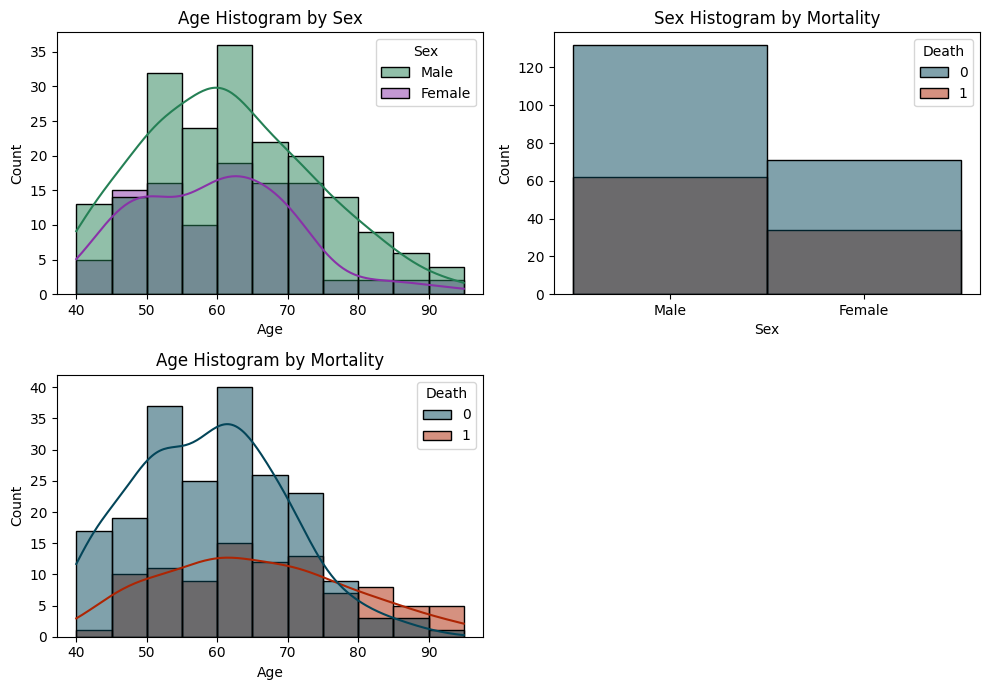

In [722]:
fig, ax = plt.subplots(2,2, figsize = (10,7))
sns.histplot(patient_df, x = 'Age', hue = 'Sex', kde = True, binwidth = 5, palette = {'Male': '#258055', 'Female': '#8932a8'}, ax = ax[0,0])
ax[0,0].set_title('Age Histogram by Sex')
sns.histplot(patient_df, x = 'Sex', hue = 'Death', palette = death_cmap, ax = ax[0,1])
ax[0,1].set_title('Sex Histogram by Mortality')
sns.histplot(patient_df, x = 'Age', hue = 'Death', kde = True, binwidth = 5, palette = death_cmap, ax = ax[1,0])
ax[1,0].set_title('Age Histogram by Mortality')
fig.delaxes(ax[1,1])
fig.tight_layout()
plt.show()

- There are more almost double the amount of men than women in this dataset.
- Even with the sex imbalance, the mortality ratio is roughly 50% in each sex.
- Age distributions looks fairly even between the sexes but with fewer older women in this data.
- Mortality rates increase as the age of the patient rises.

In [723]:
# Change sex back to binary.
patient_df.Sex = patient_df.Sex.mask(patient_df.Sex == 'Male', 1)
patient_df.Sex = patient_df.Sex.mask(patient_df.Sex == 'Female', 0)
patient_df.Sex = patient_df.Sex.astype(int)

Let's also take a look at `Follow_Up_Days` since this features seems to have a wide range and is likely effected by the most outside factors.

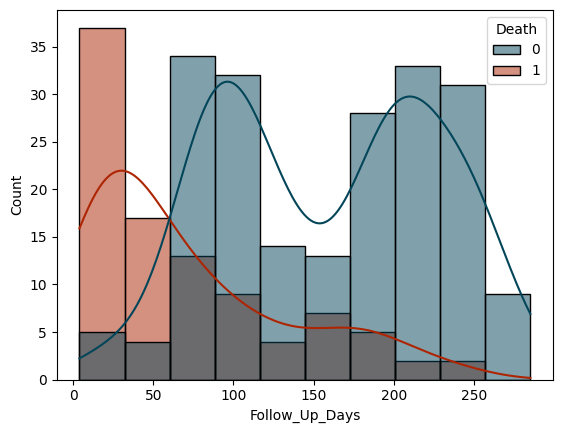

In [724]:
sns.histplot(patient_df, x = 'Follow_Up_Days', hue = 'Death', kde = True, palette = death_cmap)
plt.show()

This shows an interesting distribution between the two classes of Survival or Death. Survivors have a bimodal distribution where patients are typically following up at a much later date. Though the data won't show us why this is, we can guess as to why this is.

It is possible that the patients that survived didn't have more issues following the first Cardiovascular Disease (CVD) event that resulted in readmittance to the hospital. It is also likely that patients with higher risks of further issues were correctly identified by their doctor and follow-up appointments were advised.

Now let's take a look at the distributions of all the numerical features regardless of their target class.

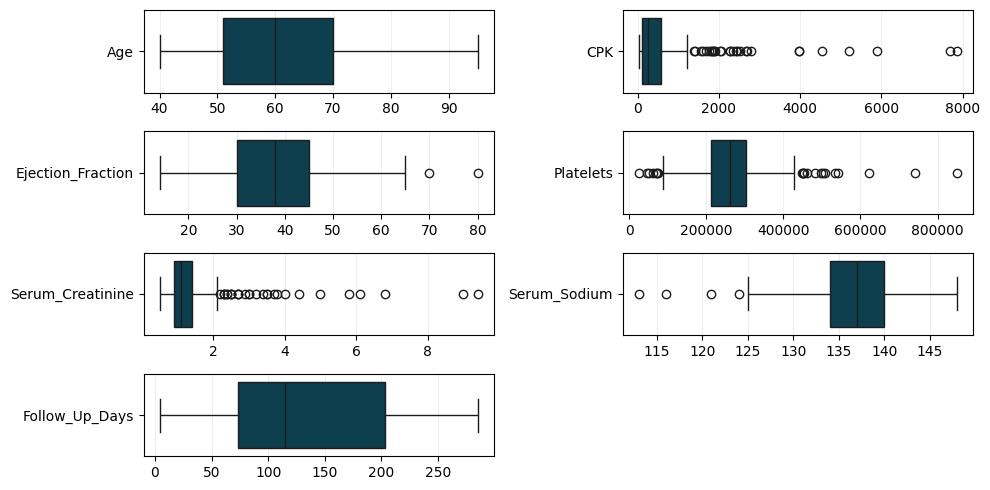

In [725]:
fig, ax = plt.subplots(np.ceil(len(numerical_cols)/2).astype(int), 2, figsize = (10,5))
for i, col in enumerate(numerical_cols):
    sns.boxplot(patient_df[col].to_frame().melt(), y = 'variable', x = 'value', color = '#034559', ax = ax[i//2,i%2])
    ax[i//2,i%2].set_ylabel('')
    ax[i//2,i%2].set_xlabel('')
    ax[i//2,i%2].grid(True, axis = 'x', alpha = 0.2)

fig.delaxes(ax[(3,1)]) # Removes empty plot.
fig.tight_layout()
plt.show()

The many outliers in Serum_Creatinine, CPK, and Platelets leads to questions about the distributions in respect to death, and if those distributions are significantly different.

We can use the mean (or median) as a snapshot to estimate the distribution differences between those patients who survived or not.

In [726]:
patient_df.groupby('Death').mean()

,Age,Anaemia,CPK,Diabetes,Ejection_Fraction,Hypertension,Platelets,Serum_Creatinine,Serum_Sodium,Sex,Smoker,Follow_Up_Days
Death,,,,,,,,,,,,
0,58.758621,0.408867,540.054187,0.418719,40.26601,0.325123,266657.489901,1.184877,137.216749,0.650246,0.325123,158.339901
1,65.208333,0.479167,670.197917,0.416667,33.46875,0.406250,256381.044792,1.835833,135.375000,0.645833,0.312500,70.885417


A few notable insights here:
- The distribution of patients who did not survive tends to be older, with a mean age of ~65 versus ~59.
- The levels of CPK is higher on average in those patients that died.
- Patients that died have weaker hearts, with lower ejection fractions.
- Serum Creatinine levels are also higher on average in those patients that died.

It is important to note that these insights alone do not represent causation or even statistically significant correlation at this point.

In addition to the information above, a pairplot can help give a slightly more detailed view of these distributions.

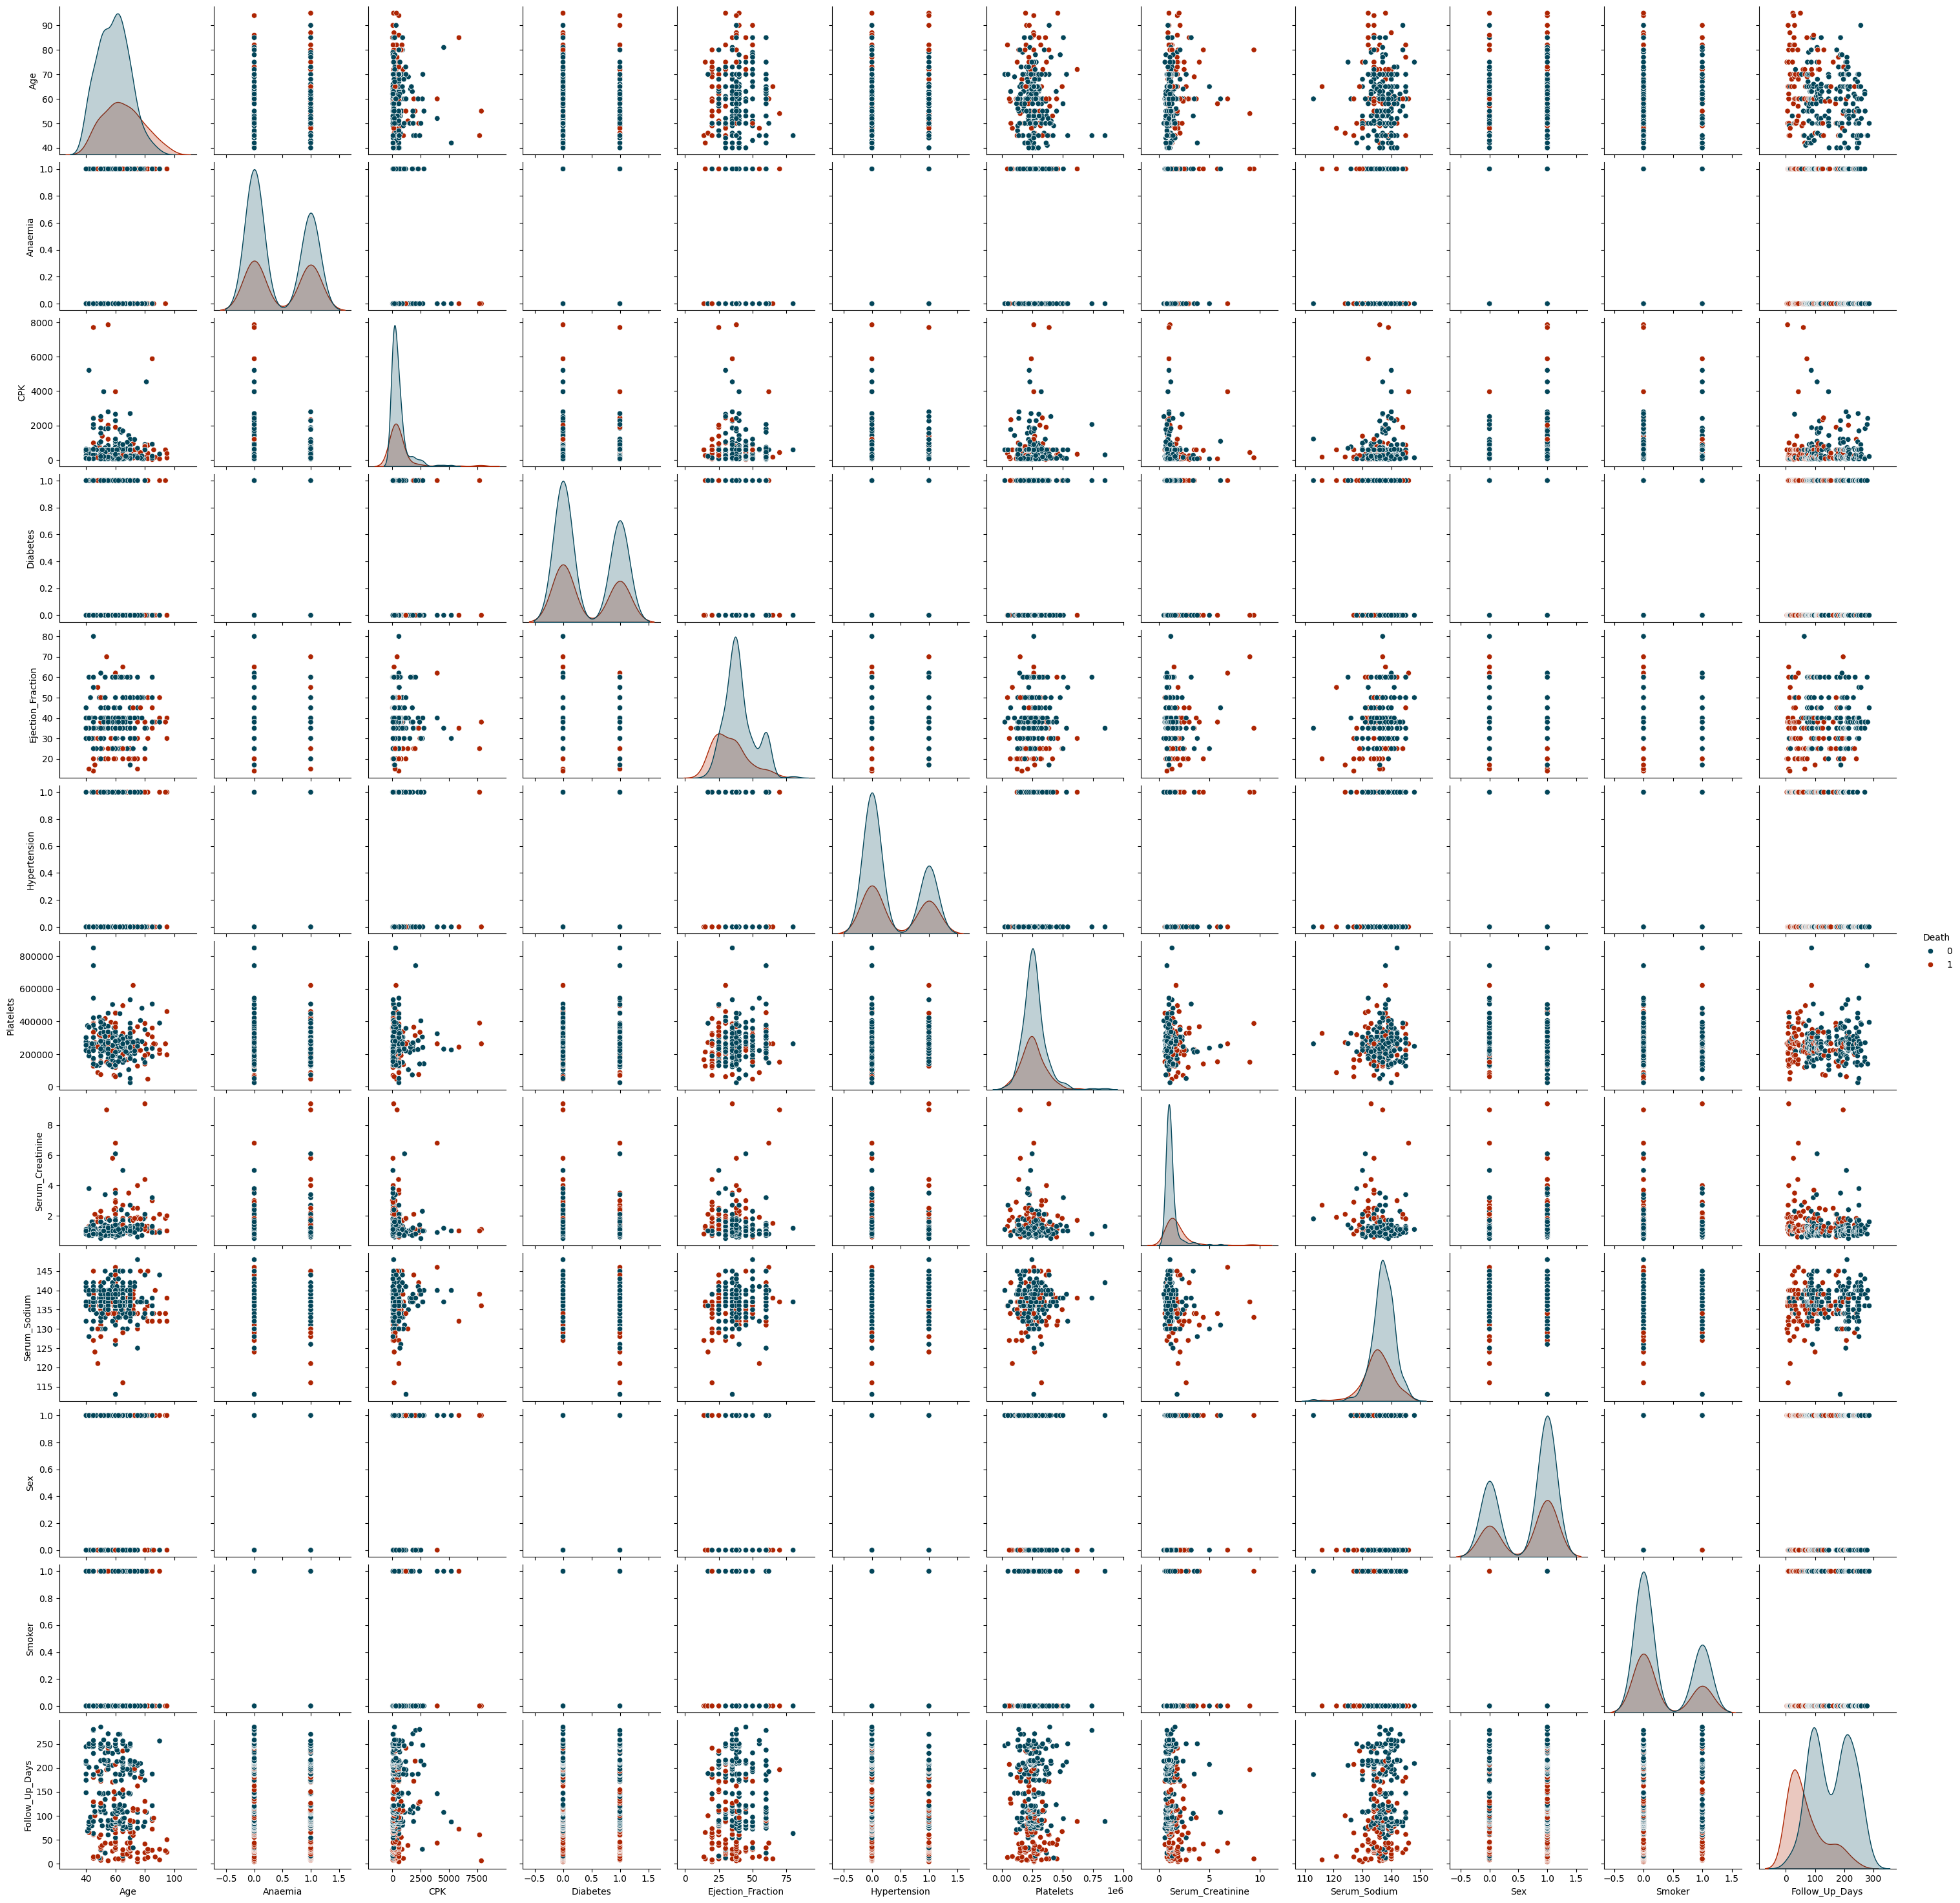

In [727]:
sns.pairplot(patient_df, hue = 'Death', palette = death_cmap)
plt.show()

There is a lot of information in a pairplot so let's give a few key insights:

- `Ejection_Fraction` vs `Age`, `Serum_Creatinine`, `CPK` there seems to be a fairly obvious discriminate line between the two clusters (`Death`).
- The diagonal showing the distributions of the two target variable classes shows that many of the feature's distributions overlap, with a few exceptions that may prove to show some correlation to the target variable:
    - `Follow_Up_Days`, as we saw before.
    - `Serum_Creatinine`
    - `Ejection_Fraction`
    - `CPK`
    - `Age`
    - `Serum_Sodium` also looks to have a slightly different distribution.

Now let's take a look at the correlation scores of all the features.

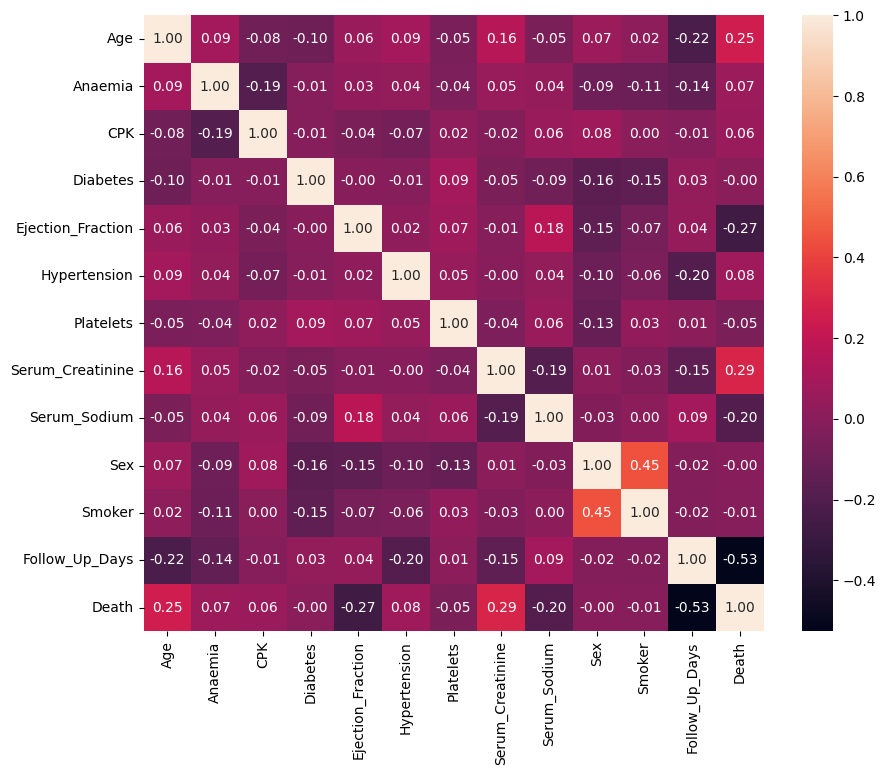

In [728]:
# Correlation.
corr_matrix = patient_df.corr()
# Plot matrix.
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr_matrix, ax = ax, annot = True, fmt = '.2f')
plt.show()

Surprisingly, there are few features that show high correlation between them.
- `Age` and `Smoker` are highly correlated, meaning there is apparently one sex that smokes much more often.
- `Serum_Sodium` and `Ejection_Fraction` show a 0.18 correlation.
- `Hypertension` and `Follow_Up_Days` scored -0.20.

There are several with correlations to the target variable `Death`.
- `Age`
- `Ejection_Fraction`
- `Serum_Creatinine`
- `Serum_Sodium`
- `Follow_Up_Days` shows the strongest correlation, but as was discussed earlier in EDA, this makes logical sense.

It's also surprising that some of the comorbidities aren't correlated here, specifically hypertension and diabetes.

It's important to note that correlation is never the full story, and only measures linear relationships. Just because some features don't show up here as correlated doesn't mean they don't have an effect on the target variable or an combined interaction with another feature.

### 4.1. Feature Scaling: <a name="scaling"></a>

Many of the upcoming models utilize a distance measure as their method of clustering, so the numerical features need to be scaled. Normalizing the feature space not only improves calculation times, but can also improve model performance.

`StandardScaler()` will be used as it centers the data by the mean and normalizes by the standard deviation, this results in a feature space that is more robust against outliers.

$Z=\frac{(X - \bar{X})}{S}$

In [729]:
# numerical_cols = patient_df.select_dtypes(include = 'number').columns
scaler = StandardScaler()#MinMaxScaler()#
patient_df[numerical_cols] = scaler.fit_transform(patient_df[numerical_cols])
patient_df.head()

,Age,Anaemia,CPK,Diabetes,Ejection_Fraction,Hypertension,Platelets,Serum_Creatinine,Serum_Sodium,Sex,Smoker,Follow_Up_Days,Death
0,1.193302,0,0.000166,0,-1.530560,1,1.681648e-02,0.490057,-1.504036,1,0,-1.629502,1
1,-0.490896,0,7.514640,0,-0.007077,0,7.535660e-09,-0.284552,-0.141976,1,0,-1.603691,1
2,0.351203,0,-0.449939,0,-1.530560,0,-1.038073e+00,-0.090900,-1.731046,1,1,-1.590785,1
3,-0.911945,1,-0.486071,0,-1.530560,0,-5.464741e-01,0.490057,0.085034,1,0,-1.590785,1
4,0.351203,1,-0.435486,1,-1.530560,0,6.517986e-01,1.264666,-4.682176,0,0,-1.577879,1


### 4.2. PCA and t-SNE: <a name="pca"></a>

Now that we've scaled the features, running a Principal Component Analysis (PCA) and plotting the top 2 principal components might give some insights about the dataset's features, projected into 2-D space, and how they relate to the target variable. 

Also, t-distributed Stochastic Neighbor Embedding (t-SNE) will be applied to the PCA embedding to attempt to further analyze the two anticipated clusters (binary target variable) and hopefully show a clearer similarity between patients.

Explained Variance Ratio per Principal Component: [0.21066359 0.16795062]


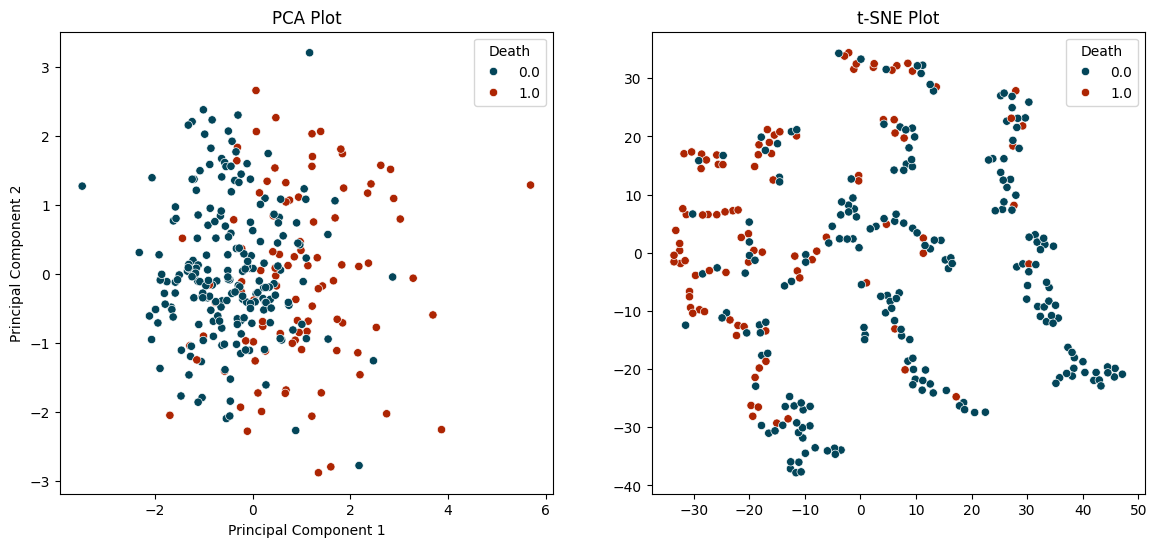

In [730]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components = 2, random_state = 21)
pca.fit(patient_df[numerical_cols])
print('Explained Variance Ratio per Principal Component:', pca.explained_variance_ratio_)
pca_df = pca.transform(patient_df[numerical_cols])
pca_df_plot = np.column_stack((pca_df, np.asarray(patient_df.Death, dtype = int)))

tsne = TSNE(n_components = 2, learning_rate = 'auto', init = 'random', perplexity = 10, random_state = 21)
tsne_df = tsne.fit_transform(pca_df)#patient_df[numerical_cols])#
tsne_df_plot = np.column_stack((tsne_df, np.asarray(patient_df.Death, dtype = int)))

# Plots
fig, ax = plt.subplots(1,2, figsize = (14,6))
# PCA
sns.scatterplot(x = pca_df_plot[:,0], y = pca_df_plot[:,1], hue = pca_df_plot[:,2], palette = death_cmap, ax = ax[0])
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
ax[0].set_title('PCA Plot')
ax[0].get_legend().set_title("Death")
# t-SNE
sns.scatterplot(x = tsne_df_plot[:,0], y = tsne_df_plot[:,1], hue = tsne_df_plot[:,2], palette = death_cmap, ax = ax[1])
ax[1].set_title('t-SNE Plot')
ax[1].get_legend().set_title("Death")
plt.show()

On the PCA Plot, the first principal component on the x-axis looks to be capturing features related to the target variable. However, there is still significant overlap, and the spread along the second component on the y-axis is seemingly random with slight clumping along the center.

On the t-SNE Plot, clustered points on the plot represent similarity "neighborhoods" using a euclidean distance metric. As was seen on the PCA plot, we see clustering of the target variable in a few different regions, but still with significant overlap.

Based on these two plots we can make the following assumptions and hypotheses:
- This dataset shows potential for predictive power.
- There is likely a blurred discriminant boundary between the two target classes.
- I anticipate models trained on this dataset will have varying sensitivity and specificity that will need to be carefully analyzed with the medical context in mind.

[Helper functions to assign the correct labels to unsupervised model predictions.]

## 5. Models <a name="models"></a>

---

### 5.1. Baseline Models: <a name="baseline"></a>

The first baseline model is simple, equal random chance at survival.

In [731]:
mod_rand_baseline = 1 / 2
print('Random Chance Baseline Accuracy:', mod_rand_baseline)

Random Chance Baseline Accuracy: 0.5


The next option is taking the most frequent class in the dataset and always predict that class.

In [732]:
most_freq_class = patient_df.Death.value_counts(sort = True).index[0]

y_pred_freq_baseline = np.full(shape = len(patient_df), fill_value = most_freq_class)
print(y_pred_freq_baseline)
print('Most Frequent Class Baseline Accuracy:', accuracy_score(y_true = patient_df.Death.astype(int), y_pred = y_pred_freq_baseline))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Most Frequent Class Baseline Accuracy: 0.6789297658862876


In [733]:
results = classification_report(patient_df.Death.astype(int), y_pred_freq_baseline, output_dict = True, zero_division = 0.0)
pd.DataFrame().from_dict(results)

,0,1,accuracy,macro avg,weighted avg
precision,0.678930,0.0,0.67893,0.339465,0.460946
recall,1.000000,0.0,0.67893,0.500000,0.678930
f1-score,0.808765,0.0,0.67893,0.404382,0.549095
support,203.000000,96.0,0.67893,299.000000,299.000000


### 5.3. Unsupervised Models: <a name="unsuper"></a>

First we need some helper functions because of the nature of unsupervised models, output predicted labels are random and need to align with the real labels. This is easily done in a binary class situation as you can just invert the score.

In [734]:
def unsuper_accuracy(y_pred):
    """
    Calculate and return accuracy for unsupervised models.
    """
    acc = accuracy_score(y_true = patient_df.Death.astype(int), y_pred = y_pred)
    return max(acc, 1-acc)

def check_unsuper_y_labels(y_pred):
    """
    Returns correctly labeled y_pred array for unsupervised models.
    """
    acc = accuracy_score(y_true = patient_df.Death.astype(int), y_pred = y_pred)
    if 1-acc > acc: # Flip labels
        return 1-y_pred # Easy way to flip 0/1 bits.
    else:
        return y_pred

#### 5.3.1. K-Prototypes Clustering: <a name="kproto"></a>

Since this dataset has 5 categorical features, we need a way to use them in unsupervised learning which typically doesn't handle them well because they usually use distance metrics to calculate centroids.

K-Prototypes is an extension of K-Mean Clustering that does just that.

In [735]:
mod_kproto = KPrototypes(n_clusters = 2,
                     max_iter = 1000,
                     n_init = 50)
y_pred_kproto = mod_kproto.fit_predict(patient_df.drop('Death', axis = 1), categorical = [1, 3, 5, 9, 10])

y_pred_kproto = check_unsuper_y_labels(y_pred_kproto)

#### 5.3.2. K-Means Clustering: <a name="kmeans"></a>

Only the numerical features will be used in K-Means here.

In [736]:
mod_kmeans = KMeans(n_clusters = 2,
                     max_iter = 1000,
                     n_init = 50)
y_pred_kmeans = mod_kmeans.fit_predict(patient_df[numerical_cols])

y_pred_kmeans = check_unsuper_y_labels(y_pred_kmeans)

#### 5.3.3. Hierarchical Clustering: <a name="hier"></a>

In [737]:
def model_optimizer_hier():
    # Function to test each combination.
    def hier_cluster_fit(data, metric, linkage):
        mod_hier_cluster = AgglomerativeClustering(n_clusters = 2, metric = metric, linkage = linkage)
        mod_hier_cluster.fit(data)
        y_pred = mod_hier_cluster.labels_
        acc = unsuper_accuracy(y_pred)
        return (acc)

    # Initialize the parameter options.
    grid = {'metric' : ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
            'linkage' : ['ward', 'complete', 'average', 'single']}

    best_acc = float('-inf')
    opt_params_hier = None

    # Test each parameter.
    for link in grid['linkage']:
        # Deal with Ward having incompatible parameters.
        if link == 'ward':
            acc = hier_cluster_fit(patient_df.drop('Death', axis = 1), 'euclidean', link)
            if acc > best_acc:
                best_acc = acc
                opt_params_hier = ('euclidean', link)
            continue # Don't need to test remaining metrics for ward linkage.
        for met in grid['metric']:
            acc = hier_cluster_fit(patient_df.drop('Death', axis = 1), met, link)
            if acc > best_acc:
                best_acc = acc
                opt_params_hier = (met, link)

    print(f'Optimized:\n Combination {opt_params_hier}\n Accuracy {best_acc}')

    return (opt_params_hier)

In [738]:
opt_params_hier = model_optimizer_hier()
mod_hier = AgglomerativeClustering(n_clusters = 2, metric = opt_params_hier[0], linkage = opt_params_hier[1], compute_distances = True)
mod_hier.fit(patient_df.drop('Death', axis = 1))
y_pred_hier = mod_hier.labels_

Optimized:
 Combination ('euclidean', 'ward')
 Accuracy 0.7725752508361204


Now we can plot the resulting dendrogram from the hierarchical clustering model.

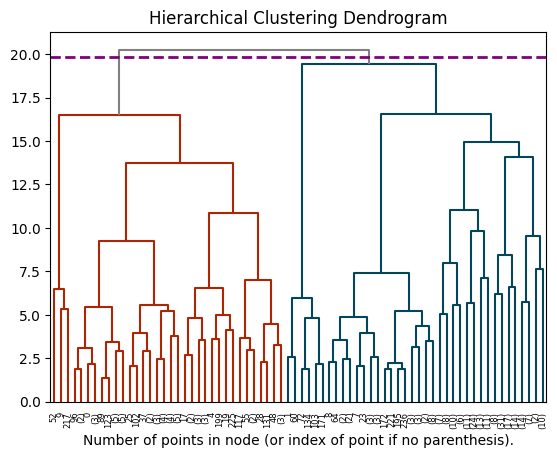

In [759]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot dendrogram.
    # From https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    # Create counts of samples under each node.
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node.
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # Plot.
    ax = plt.subplot()
    set_link_color_palette(['#ad2503', '#034559'])
    # Set color_threshold to show two clusters
    dendrogram(linkage_matrix, **kwargs, color_threshold = 20, above_threshold_color = 'grey', ax = ax)
    # Draw class threshold.
    ax.axhline(y = 19.85, lw = 2, ls = '--', c = 'purple')
    ax.set_title("Hierarchical Clustering Dendrogram")
    ax.set_xlabel("Number of points in node (or index of point if no parenthesis).")

plot_dendrogram(mod_hier, truncate_mode = "level", p = 6) # p = level to stop at.
plt.show()

I have cut the dendrogram off at 6 levels for easier visibility and added the discriminant line as a dashed purple line. 

It is interesting to think about how there are potentially 3 clusters around 18 (y-axis) or 5 around 15 (y-axis). These clusters represent sub-groups within the two target variable classes. Of course, the horizontal x-axis has no interpretation for distance between one side or the other, just the linkages between samples/clusters. 

We can see the two classes have been built up from the bottom using euclidean distance and ward linkage -- eventually connecting at 20 on the y-axis.

Now let's plot just the one level so we can verify the dendrogram results with the predicted labels. Note on the dendrogram, numbers in parentheses represent sample sizes and numbers without represent sample index.

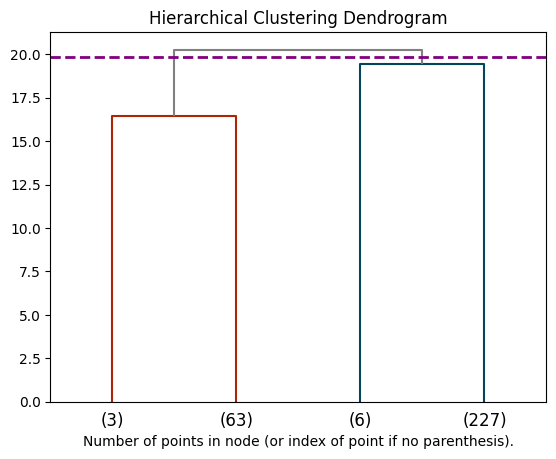

In [760]:
plot_dendrogram(mod_hier, truncate_mode = "level", p = 1) # p = level to stop at.
plt.show()

Here we can see one class has 66 predictions and the other has 233.

As a sanity check I will count the predicted labels from the model to make sure they match.

In [741]:
# Sanity check on the dendrogram vs the model predictions.
print((y_pred_hier).sum())
print((1 - y_pred_hier).sum()) # 1 - X, flips the bits for easier count.

66
233


Great, everything looks good!

### 5.4. Supervised Models: <a name="super"></a>

#### 5.4.1. Train / Test Split: <a name="split"></a>

[Talk about class balancing, not splitting for unsupervised models, and size of dataset issues.]

[Note: Typically would separate the target variable during the split but leaving it makes the custom optimization more convenient. All fits will have the target variable dropped from the feature array.]

In [742]:
X_train, X_test = train_test_split(patient_df, train_size = 0.8, stratify = patient_df.Death, random_state = 21)

class_balance_train_s, class_balance_train_d = X_train.Death.value_counts()
class_balance_test_s, class_balance_test_d = X_test.Death.value_counts()
print('Class Ratio of Deaths to Total in Train:', class_balance_train_d / (class_balance_train_s + class_balance_train_d))
print('Class Ratio of Deaths to Total in Test:', class_balance_test_d / (class_balance_test_s + class_balance_test_d))

Class Ratio of Deaths to Total in Train: 0.32217573221757323
Class Ratio of Deaths to Total in Test: 0.31666666666666665


#### 5.4.2. XGBoost <a name="xgb"></a>

As always it is beneficial to compare models against a gradient boosted tree model because of their ability to generalize and perform well on most datasets.

In [743]:
def model_optimizer_xgb(param_grid_xgb, train_df, k_folds = 3):
    params_permut = list(itertools.product(*param_grid_xgb.values()))  
    print(f'The number of parameter combinations to be tested: {len(params_permut)}')
    print(f'The number of models tested with cross-validation: {len(params_permut) * k_folds}')

    opt_array = np.full((len(params_permut) * k_folds, len(param_grid_xgb) + 4), fill_value = np.nan, dtype = 'O')
    opt_log_loss = float('inf')
    opt_params_xgb = None

    cross_val = KFold(n_splits = k_folds, shuffle = True)

    for i, par in enumerate(params_permut):
        current_params = dict(zip(param_grid_xgb.keys(), par))
        if i % 10 == 0:
            print('Current Combo:', i+1, '| Params:', current_params)

        fold_log_loss = []

        for train_index, val_index in cross_val.split(train_df):
            train_fold = train_df.iloc[train_index].copy()
            val_fold = train_df.iloc[val_index].copy()
        
            #XGBoost
            mod_xgb = xgb.XGBClassifier(booster = 'gbtree',
                                n_estimators = 6000,
                                max_depth = current_params['max_depth'],
                                learning_rate = current_params['learning_rate'],
                                gamma = current_params['gamma'],
                                early_stopping_rounds = 500,
                                objective = 'binary:hinge')

            mod_xgb.fit(train_fold.drop('Death', axis = 1), train_fold['Death'],
                        eval_set = [(val_fold.drop('Death', axis = 1), val_fold['Death'])],
                        verbose = False)

            fold_log_loss.append(mod_xgb.best_score)

        avg_log_loss = np.mean(fold_log_loss)
        model_results = list(par) + fold_log_loss + [avg_log_loss]
        opt_array[i] = model_results
        
        if avg_log_loss < opt_log_loss:
            opt_log_loss = avg_log_loss
            opt_params_xgb = current_params
            print('   Loss Decreased!!!', opt_log_loss, 'Current Combo:', i+1, '| Params:', current_params)

    print(f'Optimized Model:\n  Parameters - {opt_params_xgb}\n  Cross-Val Log Loss - {opt_log_loss}')
    # Save results to dataframe.
    column_names = list(param_grid_xgb.keys()) + ['val_loss_1','val_loss_2','val_loss_3','val_loss_avg']
    opt_df = pd.DataFrame(opt_array, columns = column_names)

    return (opt_params_xgb, opt_log_loss, opt_df)

In [744]:
# Comment out after running.
# Optimization Grid
param_grid_xgb = {'max_depth' : [1,3,5,10,None],
              'learning_rate' : [0.1,0.05,0.01],
              'gamma' : [0.05,0.1,0.5,1,5]}
opt_params_xgb, opt_log_loss_xgb, opt_df_xgb = model_optimizer_xgb(param_grid_xgb = param_grid_xgb, train_df = X_train, k_folds = 3)

The number of parameter combinations to be tested: 75
The number of models tested with cross-validation: 225
Current Combo: 1 | Params: {'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.05}
   Loss Decreased!!! 0.14651898734177216 Current Combo: 1 | Params: {'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.05}
   Loss Decreased!!! 0.13797468354430378 Current Combo: 3 | Params: {'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.5}
   Loss Decreased!!! 0.13375527426160336 Current Combo: 4 | Params: {'max_depth': 1, 'learning_rate': 0.1, 'gamma': 1}
Current Combo: 11 | Params: {'max_depth': 1, 'learning_rate': 0.01, 'gamma': 0.05}
Current Combo: 21 | Params: {'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.05}
Current Combo: 31 | Params: {'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.05}
Current Combo: 41 | Params: {'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.05}
Current Combo: 51 | Params: {'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.05}
Current Combo: 61 | Params: {'max

In [745]:
#XGBoost
mod_xgb = xgb.XGBClassifier(booster = 'gbtree',
                    n_estimators = 6000,
                    max_depth = opt_params_xgb['max_depth'],
                    learning_rate = opt_params_xgb['learning_rate'],
                    gamma = opt_params_xgb['gamma'],
                    early_stopping_rounds = 500,
                    objective = 'binary:hinge')

mod_xgb.fit(X_train.drop('Death', axis = 1), X_train.Death,
            eval_set = [(X_train.drop('Death', axis = 1), X_train.Death)],
            verbose = None)

mod_xgb.best_score
y_pred_xgb = mod_xgb.predict(X_test.drop('Death', axis = 1))

#### 5.4.1. Support Vector Machine: <a name="svm"></a>

In [746]:
# We'll use sklearn's grid search for optimizing this time.
# Comment out to save rerun time, though only takes about 7 minutes.

params = {'C' : [0.01,1,5,10,12,15], 
          'gamma' : [0.001,0.01,1,5,8,10], 
          'kernel' : ['rbf', 'linear']}

grid_svm = GridSearchCV(SVC(), param_grid = params, cv = 3, verbose = 0).fit(X_train.drop('Death', axis = 1), X_train.Death)

mod_svm = grid_svm.best_estimator_
opt_params_svm = grid_svm.best_params_

print(mod_svm)
print(mod_svm.score(X_train.drop('Death', axis = 1), X_train.Death))

SVC(C=12, gamma=0.01)
0.8619246861924686


In [747]:
# SVM
mod_svm = SVC(C = opt_params_svm['C'], 
                gamma = opt_params_svm['gamma'], 
                kernel = opt_params_svm['kernel'])
mod_svm.fit(X_train.drop('Death', axis = 1), X_train.Death)


print(f'Modeling using optimized parameters:\n {opt_params_svm}')
print('Training Set Accuracy:', mod_svm.score(X_train.drop('Death', axis = 1), X_train.Death))

y_pred_svm = mod_svm.predict(X_test.drop('Death', axis = 1))

Modeling using optimized parameters:
 {'C': 12, 'gamma': 0.01, 'kernel': 'rbf'}
Training Set Accuracy: 0.8619246861924686


## 6. Results <a name="results"></a>

---

As discussed during the training and testing split section, the classes within the dataset are imbalanced with a roughly 30% mortality rate. Due to this fact, accuracy is an improper evaluation metric to compare across models. 

The macro averaged F1-Score between the classes will be used to compare models due to it considering the precision and recall of the model, adjusting for the inherit class imbalance.

In [748]:
# Highlight the best model's test results green at each proportion.
def max_value_highlight(df):
    max_test_rows = df.max()
    is_max = (df == max_test_rows)
    
    return ['background-color:green' if v else '' for v in is_max]

# Highlight the top two results in each column blue so that 2nd place is in blue after .apply().
def highlight_top_two(df):
    # Sort values
    sorted_df = df.sort_values(ascending = False)
    top_two = sorted_df.iloc[:2]
    # Mask
    is_top_two = df.isin(top_two)

    return ['background-color: blue' if v else '' for v in is_top_two]

In [749]:
def eval_report(y_pred_dict):
    results_dict = {}
    for model, y_pred in y_pred_dict.items():
        if model in ['K-Proto', 'K-Means', 'Hierarchical']:
            results = f1_score(patient_df.Death.astype(int), y_pred, average = 'macro')
        else:
            results = f1_score(X_test.Death.astype(int), y_pred, average = 'macro')
        results_dict[model] = results,

    return results_dict

In [750]:
def confusion_matrix_subplot(y_pred_dict):
    fig, ax = plt.subplots(int(np.ceil(len(y_pred_dict) / 3)), 3, figsize = (10, 8), sharey = True)
    for i, (model, y_pred) in enumerate(y_pred_dict.items()):
        # Deal with different y_true in super/unsuper.
        if model in ['K-Proto', 'K-Means', 'Hierarchical']:
            y_true = patient_df.Death.astype(int)
        else:
            y_true = X_test.Death.astype(int)

        cm = confusion_matrix(y_true, y_pred, labels = y_true.unique(), normalize = 'all')
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = y_true.sort_values().unique())
        disp.plot(ax = ax[i // 3, i % 3])
        disp.ax_.set_title(str(model).partition('(')[0])
        disp.im_.colorbar.remove()

    # Check if odd number of models and delete last subplot if true.
    if len(y_pred_dict) % 2 != 0:
        fig.delaxes(ax[i // 3, (len(y_pred_dict) % 3)])
    fig.tight_layout()
    plt.subplots_adjust(wspace = 0.2, hspace = 0)
    fig.colorbar(disp.im_, ax = ax)
    fig.suptitle('Confusion Matrices of All Models')
    
    return None

In [751]:
y_pred_dict = {'K-Proto': y_pred_kproto,
               'K-Means': y_pred_kmeans,
               'Hierarchical': y_pred_hier,
               'XGBoost': y_pred_xgb,
               'SVM': y_pred_svm}

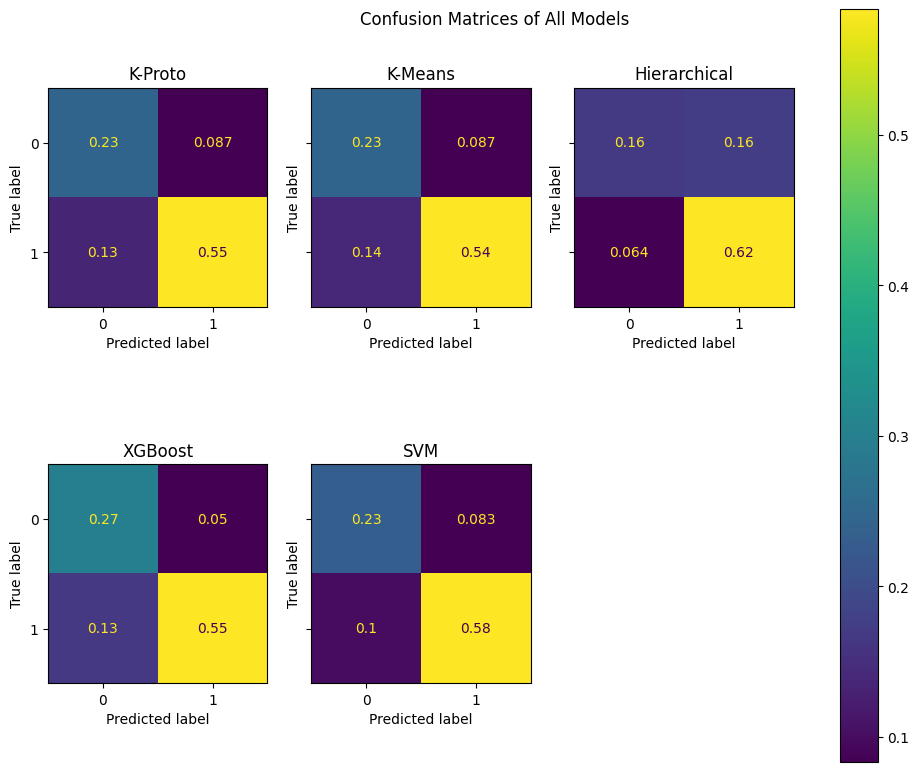

In [752]:
confusion_matrix_subplot(y_pred_dict)

In [753]:
results_dict = eval_report(y_pred_dict)
results_df = pd.DataFrame().from_dict(results_dict, orient = 'index', columns = ['F1-Score'])
results_df.style.apply(highlight_top_two).apply(max_value_highlight)

,F1-Score
K-Proto,0.755622
K-Means,0.752487
Hierarchical,0.712142
XGBoost,0.800664
SVM,0.791073


In [754]:
top_two_results = results_df.sort_values(by = 'F1-Score', ascending = False).iloc[:2]
print(top_two_results.index[0])
results = classification_report(X_test.Death.astype(int), y_pred_dict[top_two_results.index[0]], output_dict = True)
display(pd.DataFrame().from_dict(results))
print(top_two_results.index[1])
results = classification_report(X_test.Death.astype(int), y_pred_dict[top_two_results.index[1]], output_dict = True)
display(pd.DataFrame().from_dict(results))

XGBoost


,0,1,accuracy,macro avg,weighted avg
precision,0.916667,0.666667,0.816667,0.791667,0.837500
recall,0.804878,0.842105,0.816667,0.823492,0.816667
f1-score,0.857143,0.744186,0.816667,0.800664,0.821373
support,41.000000,19.000000,0.816667,60.000000,60.000000


SVM


,0,1,accuracy,macro avg,weighted avg
precision,0.875000,0.700000,0.816667,0.787500,0.819583
recall,0.853659,0.736842,0.816667,0.795250,0.816667
f1-score,0.864198,0.717949,0.816667,0.791073,0.817885
support,41.000000,19.000000,0.816667,60.000000,60.000000


## 7. Conclusion <a name="conclusion"></a>

---

Limitations:

K-Means / K-Prototypes:

The way the algorithm works, assumes clusters have a spherical shape and equal variance, this rarely fits real-world hyper-dimensional data. Also, the random initialization of centroids in the K-algorithm means you might not find the same optima between iterations.

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

1. Another paper published in 2020 utilizing machine learning and this dataset: https://doi.org/10.1186/s12911-020-1023-5

 Exported to HTML via command line using:

- `jupyter nbconvert BBC_News_Classification.ipynb --to html`
- `jupyter nbconvert BBC_News_Classification.ipynb --to html --HTMLExporter.theme=dark`

###### [Back to Table of Contents](#toc)